In [1]:
import torch
import torchvision
import random
from shapely.geometry import box
from shapely.geometry import Polygon as shapely_poly
import numpy as np
import pickle

/Users/hemanth/ENTER/envs/torch-nightly/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) #loading the mask_rcnn from pytorch libraries
# model.eval() # sets the model into evaluation mode
%cd /Users/hemanth/ParkingSpaceDetection/yolov5
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True)  # force_reload = recache latest code

/Users/hemanth/ParkingSpaceDetection/yolov5


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/hemanth/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-4-18 Python-3.8.13 torch-1.14.0.dev20221110 CPU

Fusing layers... 


requirements: /Users/hemanth/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [4]:
def compute_overlaps(parked_car_boxes, car_boxes): # We have written this function to compute the overlaps
    new_car_boxes = []#creating the carboxes array that stores the 4 points of each box 
    for box in car_boxes:
        x1 = box[0]
        y1 = box[1]
        x2 = box[2]
        y2 = box[3]
        p1 = (x1, y1)
        p2 = (x2, y1)
        p3 = (x2, y2)
        p4 = (x1, y2)
        new_car_boxes.append([p1, p2, p3, p4]) #updating the carboxes array with each box specified with all 4 vertices
    overlaps = np.zeros((len(parked_car_boxes), len(new_car_boxes))) #creating a 2D array which contains the overlapped area(IOU) between each carbox and parking spaces
    for i in range(len(parked_car_boxes)):
        for j in range(len(new_car_boxes)):
            pol1_xy = parked_car_boxes[i]
            pol2_xy = new_car_boxes[j]
            polygon1_shape = shapely_poly(pol1_xy) #converting the set of 4 vertices into a polygon object using shapely_poly
            polygon2_shape = shapely_poly(pol2_xy) 

            #calculating the IOU and storing them in 2D array

            polygon_intersection = polygon1_shape.intersection(polygon2_shape).area 
            slot_area = polygon1_shape.area
            # IOU = polygon_intersection
            IOU = polygon_intersection / slot_area
            overlaps[i][j] = IOU
    return overlaps


In [5]:
from PIL import Image
from torchvision import transforms as T #transforms is a pytorch library which contains  some functions for normalizing etc that can be applied on numpy arrays or pytorch tensors
import numpy as np

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high res images

In [7]:
import cv2

In [8]:
def get_predictions(img_path, threshold=0.5, rect_th=5,
                          text_size=0.4, text_th=3):
  car_boxes = []
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

  results2 = model(img_path, size=640)  # inference with autoshape
  results2.pandas().xyxy[0]
  boxes = results2.pandas().xyxy[0][results2.pandas().xyxy[0]['class'] == 2]
  #remove all information except bounding boxes 
  boxes = boxes[['xmin', 'ymin', 'xmax', 'ymax']]
  #convert boxes into a normal 2D array
  boxes = boxes.to_numpy()
  #convert boxes into a list of tuples
  boxes = [tuple(x) for x in boxes]

  for i in range(len(boxes)):
    pt1 = pt1 = (int(boxes[i][0]), int(boxes[i][1]))#extracting the two diagonal points of the car box so that we will be able to draw a box around that object using cv2
    pt2 = (int(boxes[i][2]), int(boxes[i][3]))
    car_boxes.append([pt1[0], pt1[1], pt2[0], pt2[1]])
    cv2.rectangle(img, pt1, pt2, color=(255, 255, ), thickness=rect_th)
  return img, car_boxes


In [9]:
img, car_boxes = get_predictions('/Users/hemanth/ParkingSpaceDetection/scene1.png', rect_th=1, text_th=1)

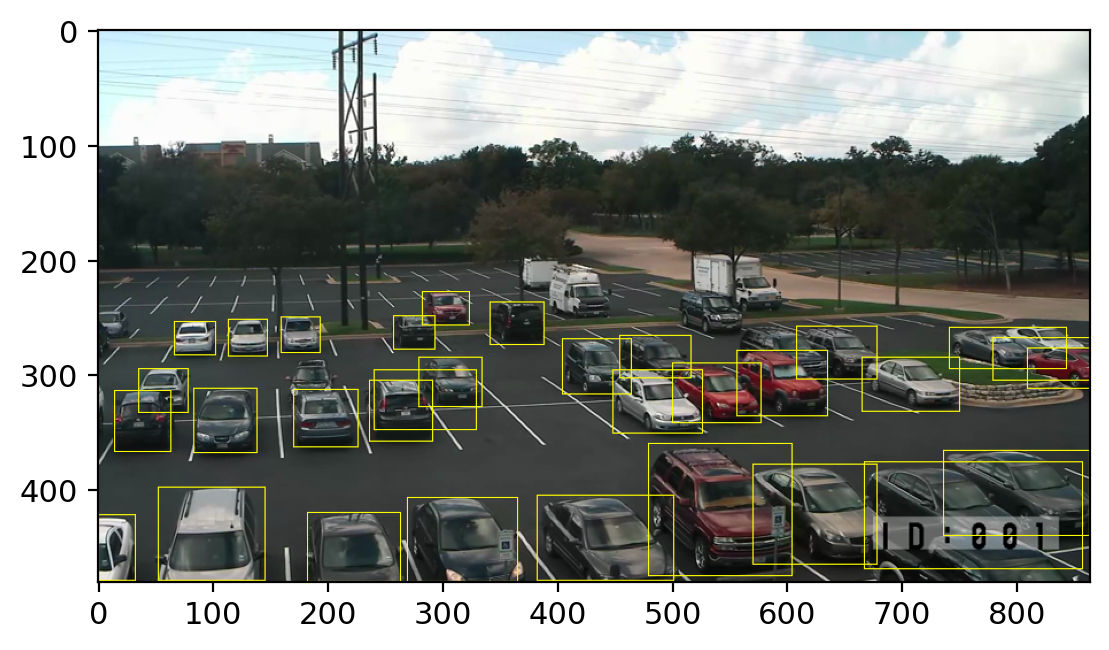

In [10]:
plt.imshow(img)

In [14]:
alpha = 0.6
regions_path = "/Users/hemanth/ParkingSpaceDetection/regions2.p"
with open(regions_path, 'rb') as f:
    parked_car_boxes = pickle.load(f)

overlap_areas = compute_overlaps(parked_car_boxes, np.array(car_boxes))
count =0

for parking_area, overlap_area in zip(parked_car_boxes, overlap_areas):
    # max_IoU_overlap = np.max(overlap_area)/parking_area
    max_IoU_overlap = np.max(overlap_area)
    if max_IoU_overlap > 0.55:
        count = count+1
        cv2.fillPoly(img, [np.array(parking_area)], (255, 0, 0))
    else:
        cv2.fillPoly(img, [np.array(parking_area)], (0, 255, 0))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

filename = 'result.jpg'
cv2.imwrite(filename, img)
print(count, " Parking spaces are occupied out of ", len(parked_car_boxes))

2  Parking spaces are occupied out of  4


In [13]:
%pwd

'/Users/hemanth/ParkingSpaceDetection/yolov5'

In [ ]:
from IPython.display import clear_output
import base64
from IPython.display import Image as Ig
import time

In [ ]:
def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Ig(data=encoded.decode('ascii'))

In [ ]:
%cd /Users/hemanth/ParkingSpaceDetection
alpha = 0.6
VIDEO_SOURCE = "/Users/hemanth/ParkingSpaceDetection/video1.mp4"
video_capture = cv2.VideoCapture(VIDEO_SOURCE)
cnt=0

video_FourCC    = cv2.VideoWriter_fourcc('M','J','P','G')
video_fps       = video_capture.get(cv2.CAP_PROP_FPS)
video_size      = (int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
                    int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
out = cv2.VideoWriter("out.avi", video_FourCC, video_fps, video_size)

frame_interval = 1000 # Interval between frames in milliseconds

while video_capture.isOpened():
    # Extract the current position of the video in milliseconds
    current_pos = video_capture.get(cv2.CAP_PROP_POS_MSEC)
    
    # Extract the next frame at the frame interval
    next_pos = current_pos + frame_interval
    video_capture.set(cv2.CAP_PROP_POS_MSEC, next_pos)
    success, frame = video_capture.read()
    if not success:
        break
    overlay = frame.copy()

    rgb_image = frame[:, :, ::-1]
    # results = model.detect([rgb_image], verbose=0)
    # car_boxes = get_car_boxes(results[0]['rois'], results[0]['class_ids'])
    filename = 'temp_frame.jpg'
    cv2.imwrite(filename, rgb_image)
    img, car_boxes = get_predictions('temp_frame.jpg', rect_th=1, text_th=1)
    
    overlaps = compute_overlaps(parked_car_boxes, np.array(car_boxes))

    for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):
        max_IoU_overlap = np.max(overlap_areas)
        if max_IoU_overlap > 0.75:
            cv2.fillPoly(overlay, [np.array(parking_area)], (0, 100, 0))
        else:
            cv2.fillPoly(overlay, [np.array(parking_area)], (255, 0, 0))

    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)
    for i in range(20):
        out.write(frame)
    # filename = 'temp_frame1.jpg'
    # cv2.imwrite(filename, frame)
    # cv2.imshow('Video', frame)
    clear_output(wait=True)
    img = arrayShow(frame)
    # display(img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
out.release()
cv2.destroyAllWindows()